In [20]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from biodatatools.utils.common import json_load
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import itertools

In [5]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [6]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Multi-classifier training

In [22]:
p = "divergent"
ds = ["distal", "proximal"]

In [11]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")

In [13]:
# Use samples highlighted in Fig.2A for model training

df = pd.read_table(f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt", header=None)
n_samples = list(df[0])
m_samples = groups["metastatic_cancer"]

In [16]:
len(n_samples), len(m_samples)

(93, 23)

In [18]:
cdict = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/color_codes.json")
ts = list(cdict)

In [27]:
cutoff = 0.05
tres = defaultdict(dict)
for d, t in itertools.product(ds, ts):
	t2 = "_".join(t.split(" "))
	df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/tstats_{p}_{d}_{t2}.txt", index_col=0)
	top = int(cutoff * len(df))
	tres[(p,d)][t] = set(df["tstats"].nlargest(top).index)

In [30]:
# Here we only focus on elements uniquely found in one group

tres_unique = defaultdict(set)
for k in tres:
    counts = Counter(v for values in tres[k].values() for v in values)
    tres_unique[k] = [v for values in tres[k].values() for v in values if counts[v] == 1]

In [31]:
df_train = {}
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
for d in ds:
	df_train[(p,d)] = df_exp[n_samples].loc[tres_unique[(p,d)]]

In [32]:
# Evaluate the model using cross-validation
# Stratified 3-Fold Cross-Validation (each class with at least 3 samples)
# The folds are made by preserving the percentage of samples for each class

skf = StratifiedKFold(n_splits=3)

In [33]:
# Mean cross-validation accuracy

models = {}
for k in df_train:
	train_X = df_train[k].T.to_numpy()
	train_Y = [labels[s][1] for s in n_samples]
	models[k] = SVC(kernel="linear", probability=True)
	models[k].fit(train_X, train_Y)
	scores = cross_val_score(models[k], train_X, train_Y, cv=skf, scoring="accuracy")
	print(k, np.mean(scores))

('divergent', 'distal') 1.0
('divergent', 'proximal') 1.0


Text(0.5, 0, 'True label')

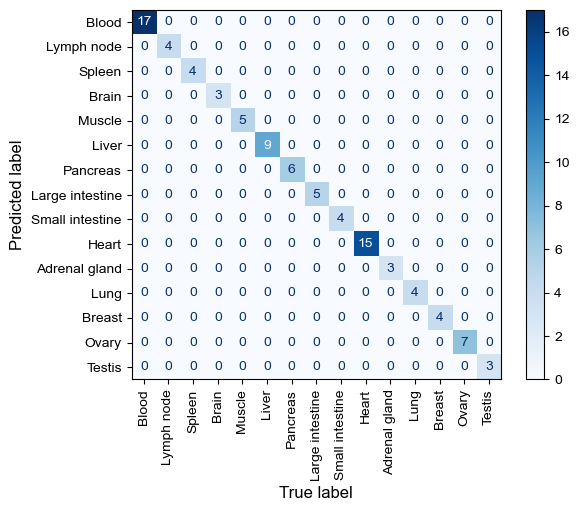

In [36]:
k = ("divergent", "distal")
train_X = df_train[k][n_samples].T.to_numpy()
train_pred_Y = models[k].predict(train_X)
cm = confusion_matrix(train_pred_Y, train_Y, labels=list(cdict))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(cdict))
disp.plot(cmap="Blues")
plt.xticks(rotation=90)
plt.ylabel("Predicted label", fontsize=bfontsize)
plt.xlabel("True label", fontsize=bfontsize)

# Predict primary sites of metastatic samples

In [58]:
val_pred_Y = {}
val_pred_Y_prob = {}
for k in models:
	val_X = df_exp[m_samples].loc[tres_unique[k]].T.to_numpy()
	val_pred_Y[k] = models[k].predict(val_X)
	val_pred_Y_prob[k] = models[k].predict_proba(val_X)

In [78]:
acc = {}
for k in models:
	acc[k] = defaultdict(int)
	ranked_preds[k] = {}
	for s in m_samples:
		ind = m_samples.index(s)
		true_label = labels[s][0]
		sorted_idx = np.argsort(val_pred_Y_prob[k][ind])[::-1]
		sorted_labels = [models[k].classes_[i] for i in sorted_idx]
		for n in range(1,6):
			if n == 1:
				if true_label == val_pred_Y[k][ind]:
					acc[k][f"top{n}"] += 1
			else:
				if true_label in sorted_labels[:n]:
					acc[k][f"top{n}"] += 1

In [94]:
results = []
for p, d in acc:
	for k in acc[(p,d)]:
		results.append([p, d.capitalize(), k.capitalize(), acc[(p,d)][k], len(m_samples), acc[(p,d)][k]/len(m_samples)])
df_acc = pd.DataFrame(results, columns=["group1", "group2", "top", "correct", "total", "accuracy"])
df_acc.head(2)

,group1,group2,top,correct,total,accuracy
0,divergent,Distal,Top1,20,23,0.869565
1,divergent,Distal,Top2,21,23,0.913043


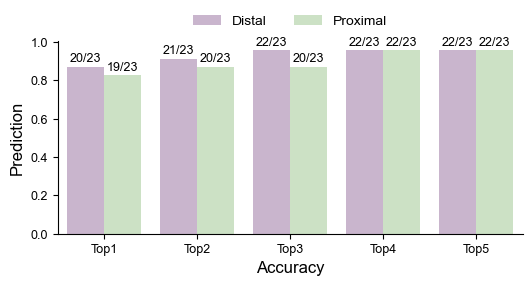

In [96]:
fig, ax = plt.subplots(figsize=(6,2.5))

g = sns.barplot(data=df_acc, x="top", y="accuracy", hue="group2", palette=["#CBB1D1", "#CAE5C1"])
g.spines[["top", "right"]].set_visible(False)
g.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncols=2, frameon=False)
g.set_xlabel("Accuracy", fontsize=bfontsize)
g.set_ylabel("Prediction", fontsize=bfontsize)
g.tick_params(labelsize=sfontsize)

for p, (_, row) in zip(g.patches, df_acc.iterrows()):
    height = p.get_height()
    g.text(
        p.get_x() + p.get_width() / 2,
        height + 0.01,                
        f'{row["correct"]}/{row["total"]}',
        ha='center',
        va='bottom',
        fontsize=sfontsize
    )

plt.savefig(f"{PROJECT_DIR_o}figures/SuppFig10b.pdf", bbox_inches="tight", transparent=True) 

In [103]:
# Show heatmap of predicted fractions
# Rows: true label for primary sites
# Columns: predicted label for metastatic sites

k = ('divergent', 'distal')
counts = {}
for s in m_samples:
	psite, msite = labels[s]
	if "Brain" in msite:
		msite = "Brain"
	if (psite, msite) not in counts:
		counts[(psite, msite)] = defaultdict(int)
	ind = m_samples.index(s)
	counts[(psite, msite)][val_pred_Y[k][ind]] += 1

In [104]:
counts

{('Breast', 'Ovary'): defaultdict(int, {'Breast': 3}),
 ('Breast', 'Brain'): defaultdict(int, {'Breast': 9, 'Lung': 1}),
 ('Liver', 'Adrenal gland'): defaultdict(int, {'Liver': 2}),
 ('Large intestine',
  'Brain'): defaultdict(int, {'Small intestine': 1, 'Large intestine': 1}),
 ('Large intestine', 'Lung'): defaultdict(int, {'Large intestine': 2}),
 ('Liver', 'Lung'): defaultdict(int, {'Lung': 1, 'Liver': 1}),
 ('Lung', 'Adrenal gland'): defaultdict(int, {'Lung': 1}),
 ('Pancreas', 'Ovary'): defaultdict(int, {'Pancreas': 1})}

In [105]:
# Combine small and large intestines as one label "Intestine" for main figure

counts2 = defaultdict(dict)
for k in counts:
	if "Large intestine" in k:
		counts2[k]["Intestine"] = 2
	else:
		counts2[k] = counts[k]

In [106]:
counts2

defaultdict(dict,
            {('Breast', 'Ovary'): defaultdict(int, {'Breast': 3}),
             ('Breast', 'Brain'): defaultdict(int, {'Breast': 9, 'Lung': 1}),
             ('Liver', 'Adrenal gland'): defaultdict(int, {'Liver': 2}),
             ('Large intestine', 'Brain'): {'Intestine': 2},
             ('Large intestine', 'Lung'): {'Intestine': 2},
             ('Liver', 'Lung'): defaultdict(int, {'Lung': 1, 'Liver': 1}),
             ('Lung', 'Adrenal gland'): defaultdict(int, {'Lung': 1}),
             ('Pancreas', 'Ovary'): defaultdict(int, {'Pancreas': 1})})

In [109]:
met_order = [('Breast', 'Brain'), ('Breast', 'Ovary'), 
			 ('Large intestine', 'Lung'), ('Large intestine', 'Brain'),
			 ('Liver', 'Adrenal gland'), ('Liver', 'Lung'),
			 ('Lung', 'Adrenal gland'),
			 ('Pancreas', 'Ovary')
			]
index = [f"{k[0]}  \u2192 {k[1]}" for k in met_order]
columns = ["Breast", "Intestine", "Liver", "Lung", "Pancreas"]

In [114]:
results1 = []
results2 = []
for met in met_order:
	tot = np.sum([counts2[met][k] for k in counts2[met]])
	row1 = [0]*len(columns)
	row2 = [""]*len(columns)
	for prd in columns:
		if prd in counts2[met]:
			ind = columns.index(prd)
			row1[ind] = round(counts2[met][prd]/tot,2)
			row2[ind] = f"{counts2[met][prd]}/{tot}"
	results1.append(row1)
	results2.append(row2)
df_frac = pd.DataFrame(results1, columns=columns, index=index)
df_annots = pd.DataFrame(results2, columns=columns, index=index)

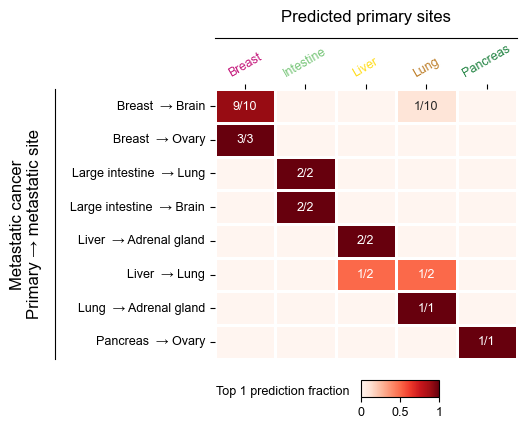

In [152]:
fig, ax = plt.subplots(figsize=(3.9,3.5))

g = sns.heatmap(df_frac, cmap="Reds", ax=ax, cbar=False, linewidths=1,
				annot=df_annots, fmt='s', annot_kws={"fontsize": sfontsize}
			   )
cbar = g.collections[0].colorbar
cbar_ax = fig.add_axes([0.5, 0, 0.2, 0.05])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.ax.text(-1, 0, "Top 1 prediction fraction", fontsize=sfontsize, 
				 ha='center', va='bottom', transform=cbar.ax.transAxes)
vlims = [0,0.5,1]
cbar.set_ticks(vlims)
cbar.set_ticklabels(vlims, fontsize=sfontsize)

g.set_title("Predicted primary sites", fontsize=bfontsize, y=1.22)
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
for tick in g.get_xticklabels():
	text = tick.get_text()
	if text != "Intestine":
		tick.set_color(cdict[text])
	else:
		tick.set_color(cdict["Large intestine"])
line_y = 1.19
g.plot([0, 1], [line_y, line_y], transform=g.transAxes, c="black", clip_on=False, lw=lw)

g.set_ylabel("Metastatic cancer\nPrimary \u2192 metastatic site", fontsize=bfontsize, labelpad=20)
line_x = -0.53
g.plot([line_x, line_x], [0, 1], transform=g.transAxes, c="black", clip_on=False, lw=lw)

g.tick_params(labelsize=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig6d.pdf", bbox_inches="tight", transparent=True) 